PRELIMINARIES

In [ ]:
!pip -q install wfdb imbalanced-learn

import os
import wfdb
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPooling1D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 27.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
!pip install wfdb
!pip install PyWavelets

import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 20.0 MB/s eta 0:00:00


In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    project_directory = '/content/drive/MyDrive/TinyML/'  # Change this path to match your Google Drive directory
    os.chdir(project_directory)
except:
    pass


Mounted at /content/drive


DATA VISUALIZATION

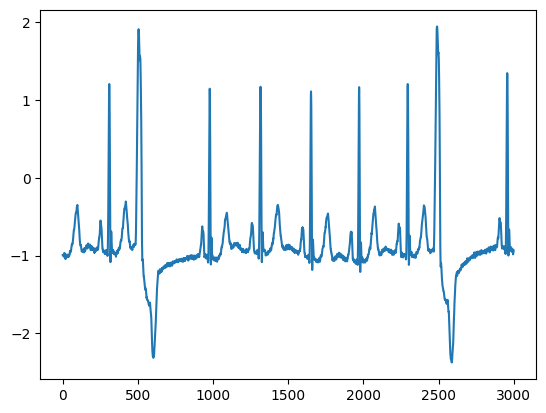

In [ ]:

# Specify the record name and path
record_name = '119'
record_path = f'./mit-bih-arrhythmia-database-1.0.0/{record_name}'

# Read the ECG record. We can optionally pass in the `sampto` parameter to read a specific number of samples. Let's try 3000.
record = wfdb.rdrecord(record_path, sampto=3000)

# Extract the ECG signal from the first lead of the record
ecg_signal = record.p_signal[:,0]

# Plotting the ECG signal
plt.plot(ecg_signal)

DATA PREPROCESSING

In [ ]:

record_name = '101'
record_path = f'./mit-bih-arrhythmia-database-1.0.0/{record_name}'
record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(record_path, 'atr')

In [ ]:
peaks = annotation.sample
symbols = annotation.symbol

In [ ]:

print(peaks[:10])
print(symbols[:10])

[   7   83  396  711 1032 1368 1712 2036 2349 2662]
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


In [ ]:

data_path = './mit-bih-arrhythmia-database-1.0.0/'
record_list = wfdb.get_record_list('mitdb')

In [ ]:
X = []  # R-R intervals
y = []  # labels (normal = 0, arrhythmic = 1)

window_size = 10

for record_name in record_list:
    # Load the signal and annotations
    annotation = wfdb.rdann(os.path.join(data_path, record_name), 'atr')

    # Detect peaks
    peaks = annotation.sample

    # Get R-R intervals
    intervals = np.diff(peaks)

    # Normalize the intervals
    normalized_intervals = intervals / intervals.max()

    # Break up the intervals into segments of 10
    for i in range(len(intervals) - window_size + 1):
        # Get the annotations and intervals for the current window
        window_annotations = annotation.symbol[i:i + window_size]
        window_intervals = normalized_intervals[i:i + window_size]

        # Count of abnormal beats
        abnormal_count = sum(1 for ann in window_annotations if ann == 'V')

        # Select windows that are either all 'N' or have at least 2 'V's
        if all(ann == 'N' for ann in window_annotations) or (abnormal_count >= 2):
            X.append(window_intervals)
            y.append(abnormal_count >= 2)

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
X

array([[0.74692875, 0.71744472, 0.6977887 , ..., 0.73218673, 0.72727273,
        0.7027027 ],
       [0.71744472, 0.6977887 , 0.68304668, ..., 0.72727273, 0.7027027 ,
        0.70515971],
       [0.6977887 , 0.68304668, 0.74201474, ..., 0.7027027 , 0.70515971,
        0.7002457 ],
       ...,
       [0.74534161, 0.72981366, 0.74223602, ..., 0.7484472 , 0.75465839,
        0.7826087 ],
       [0.72981366, 0.74223602, 0.7484472 , ..., 0.75465839, 0.7826087 ,
        0.75776398],
       [0.74223602, 0.7484472 , 0.75776398, ..., 0.7826087 , 0.75776398,
        0.73291925]])

In [ ]:
y

array([False, False, False, ..., False, False, False])

In [ ]:
print(X.shape,y.shape)

(66782, 10) (66782,)


In [ ]:
project_path = r"/content/drive/MyDrive/TinyML/mit-bih-arrhythmia-database-1.0.0/"

# User defined fucntion for DWT and reconstruction
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

# Read ECG signals and corresponding label
def getDataSet(number, X_data, Y_data):

    # Considering 15 types ECG heartbeats that are later grouped in 5 classes
    ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']

    # Reading Channel names
    _, info = wfdb.io.rdsamp(osj(project_path, number))
    channels = info['sig_name']
    channel1, channel2 = channels[0], channels[1]
    print(channel1, channel2)


    # Read ECG data records
    print("reading " + number+ " ECG data...")
    record = wfdb.rdrecord(project_path + number, channel_names=[channel1])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    # Obtain the position and corresponding label of the R wave in the ECG data record
    annotation = wfdb.rdann(project_path + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # Unstable data before and after removal
    start = 2  # if it creates problem then except will do the job
    end = 3
    i = start
    j = len(annotation.symbol) - end

    # Making labels, Y_data Convert NSVFQ in order to 0123456...14
    while i < j:
        try:
            beat_type = Rclass[i]
            lable = ecgClassSet.index(beat_type)  # when beat is like '+' or other it will go on except loop
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            # print(f' when i = {i}, beat type is out of our choise. For example +, [, ! or other')
            i += 1
    return X_data, Y_data

# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
                 '222', '223', '228', '230', '231', '232', '233', '234'] # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # dataset and its label set
    X = train_ds[:, :300]
    Y = train_ds[:, 300]
    return X, Y

# Input X and Output Y data loading
X, Y = loadData()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [ ]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
                 '222', '223', '228', '230', '231', '232', '233', '234']  # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)
    return train_ds

train_ds = loadData()
Y = train_ds[:, 300]

# Here 15 class of ECG data are saved
Y_list = list(Y)
Counter(Y_list)

# 15 level to 5 level conversion
Y_5class = np.copy(Y)

for i in range(Y.shape[0]):
  # print(i)
  if 0 <= Y[i] <= 4:
    Y_5class[i] = 0
  if 5 <= Y[i] <= 8:
    Y_5class[i] = 1
  if 9 <= Y[i] <= 10:
    Y_5class[i] = 2
  if Y[i] == 11:
    Y_5class[i] = 3
  if 12 <= Y[i] <= 14:
    Y_5class[i] = 4
print('changing done')

Y_5class_list = list(Y_5class)
Counter(Y_5class_list)

ecg_dataset = np.copy(train_ds)

# label encode the target variable # just convert numpy.float64 to numpy.int64
from sklearn.preprocessing import LabelEncoder
Y_5class = LabelEncoder().fit_transform(Y_5class)

ecg_data = ecg_dataset[:, :300]
ecg_lable = Y_5class.reshape(-1, 1) # otherwise np.hstack will not work

# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_5 = np.hstack((ecg_data, ecg_lable))

# train test splitting
from sklearn.model_selection import train_test_split
ecg_data = ecg_dataset_5[:, :300]
ecg_label = ecg_dataset_5[:, 300]
x_train, x_test, y_train, y_test = train_test_split(ecg_data, ecg_label,
                                   random_state=104,
                                   test_size=0.20,
                                   shuffle=True)

# reshaping for using hstack function
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
train_data = np.hstack((x_train, y_train))
test_data = np.hstack((x_test, y_test))

#  converting dataframe
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

# extracting class 0 and 4 others class
train_data_0 = train_data.loc[(train_data[300] == 0)]
train_data_1234 = train_data.loc[(train_data[300] != 0)]

# 1. Class 1: Randomly selected 50000 data
from sklearn.utils import resample
train_data_0_resampled=train_data_0.sample(n=50000,random_state=42)

# convert dataframe to numpy array
train_data_0_resampled = train_data_0_resampled.to_numpy()

# 2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

# converting from df to np ndarray
train_data_1234_arr = train_data_1234.to_numpy()
X_4cl, y_4cl = train_data_1234_arr[:, :-1], train_data_1234_arr[:, -1]

from imblearn.over_sampling import SMOTE
# transform the dataset
strategy = {1:50000, 2:50000, 3:50000, 4:50000}
oversample = SMOTE(sampling_strategy=strategy)
X, y = oversample.fit_resample(X_4cl, y_4cl)

y = y.reshape(-1, 1)
train_data_1234_resampled = np.hstack((X, y))

# Join the class 0 and 1234
train_data_resampled = np.vstack((train_data_0_resampled, train_data_1234_resampled))

# shuffle the data, needed for proper training
np.take(train_data_resampled,np.random.permutation(train_data_resampled.shape[0]),axis=0,out=train_data_resampled)


MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

array([[-0.15575575, -0.15355064, -0.15102149, ..., -0.27234825,
        -0.27088458,  1.        ],
       [-0.23717742, -0.23739965, -0.23852515, ...,  0.38078771,
         0.30778594,  2.        ],
       [-0.80868834, -0.8089578 , -0.80896948, ..., -0.60760148,
        -0.60761564,  0.        ],
       ...,
       [ 0.42350667,  0.39971845,  0.37545358, ...,  2.27700136,
         2.47982081,  3.        ],
       [-0.16589094, -0.15199667, -0.13846111, ..., -0.33730115,
        -0.3371404 ,  1.        ],
       [-0.38129524, -0.38220469, -0.38351643, ..., -0.35655115,
        -0.3582608 ,  3.        ]])

In [ ]:
x_train

array([[-0.32171705, -0.32260006, -0.32344605, ..., -0.31426553,
        -0.31267429, -0.31064115],
       [-0.35051648, -0.35104433, -0.35132758, ..., -0.39344798,
        -0.4008955 , -0.40784699],
       [-0.45211706, -0.45223808, -0.45227055, ..., -0.42096927,
        -0.4211858 , -0.42167253],
       ...,
       [-0.46623771, -0.46646617, -0.46639642, ..., -0.41192213,
        -0.41188422, -0.41147437],
       [ 0.36979089,  0.35338418,  0.33806519, ...,  1.83406719,
         2.01367415,  2.08994073],
       [-0.80627935, -0.80383606, -0.80132002, ..., -0.32266998,
        -0.32603644, -0.32887006]])

In [ ]:
y_train

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [ ]:
y_train_1d = y_train.flatten()
print(y_train_1d)


[0. 0. 0. ... 0. 0. 0.]


In [ ]:
y_test

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [ ]:
y_test_1d = y_test.flatten()
print(y_test_1d)
print(y_test_1d.shape)

[0. 0. 0. ... 0. 0. 0.]
(21861,)


In [ ]:
print(x_train.shape,y_train_1d.shape)

(87444, 300) (87444,)


In [ ]:
x_train[0].shape

(300,)

In [ ]:
import tensorflow as tf

class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, filters, ratio, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.filters = filters
        self.ratio = ratio

    def build(self, input_shape):
        self.shared_dense = tf.keras.layers.Dense(
            self.filters // self.ratio, activation='relu', kernel_initializer='he_normal'
        )
        self.output_dense = tf.keras.layers.Dense(
            self.filters, activation='sigmoid', kernel_initializer='he_normal'
        )

    def call(self, inputs):
        # Use fixed AveragePooling1D instead of GlobalAveragePooling1D
        avg_pool = tf.keras.layers.AveragePooling1D(pool_size=inputs.shape[1] // 2)(inputs)
        avg_pool = tf.keras.layers.Flatten()(avg_pool)  # Ensures a fixed shape
        avg_pool = self.shared_dense(avg_pool)
        avg_pool = self.output_dense(avg_pool)

        # Use Reshape instead of ExpandDims
        avg_pool_expanded = tf.keras.layers.Reshape((1, self.filters))(avg_pool)

        attention = tf.keras.layers.Multiply()([inputs, avg_pool_expanded])
        return attention


def buildEnhancedModel():
    model = tf.keras.Sequential([
        # Input layer expects 2D input: (batch, 300)
        tf.keras.layers.InputLayer(input_shape=(300,)),  # Shape: (300,)

        # Reshape to 3D (300 timesteps, 1 feature) for Conv1D compatibility
        tf.keras.layers.Reshape((300, 1)),  # Output shape: (batch, 300, 1)

        # Convolutional layers
        tf.keras.layers.Conv1D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same'),

        tf.keras.layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same'),

        # Flatten and output layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return model


#Define the log directory, which must be a subdirectory of the specified
#directory when starting the web application. It is recommended to use date and time as the subdirectory name
logdir = project_path + "logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = project_path + "1_model.h5"

model = buildEnhancedModel()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Define the TensorBoard object
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
checkpoint_filepath=project_path + "1.weights.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                 save_weights_only=True, monitor='val_accuracy',
                                                                 mode='max', save_best_only=True)
callback_list = [tensorboard_callback, model_checkpoint_callback]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 300, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 300, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 150, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 150, 16)             │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 75, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │          38,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,029 (152.46 KB)

 Trainable params: 39,029 (152.46 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, GlobalAveragePooling1D, ReLU, MaxPooling1D
from tensorflow.keras.models import Model

# Simplified model architecture for TFLite Micro compatibility
input_shape = (300, 1)  # Directly include channel dimension
inputs = Input(shape=input_shape)

# First convolutional block
x = Conv1D(16, kernel_size=5, activation='relu', padding="same")(inputs)
x = MaxPooling1D(2)(x)  # Reduces sequence length

# Second convolutional block
x = Conv1D(32, kernel_size=3, activation='relu', padding="same")(x)
x = MaxPooling1D(2)(x)

# Third convolutional block
x = Conv1D(32, kernel_size=3, activation='relu', padding="same")(x)

# Final pooling
x = GlobalAveragePooling1D()(x)

# Reduced fully connected layers
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(5, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 300, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_20 (Conv1D)                   │ (None, 300, 16)             │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 150, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_21 (Conv1D)                   │ (None, 150, 32)             │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 75, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_22 (Conv1D)                   │ (None, 75, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,125 (35.64 KB)

 Trainable params: 9,125 (35.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# percentage of training data used for model validation
ratio = 0.2

# Training and Validation
history = model.fit(x_train, y_train_1d, epochs=20,
            batch_size=128,
            validation_split=ratio,
            callbacks=callback_list)
model.save(filepath=model_path)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.8094 - loss: 0.7983 - val_accuracy: 0.8729 - val_loss: 0.4290
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - accuracy: 0.8774 - loss: 0.4036 - val_accuracy: 0.8923 - val_loss: 0.3633
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - accuracy: 0.8937 - loss: 0.3504 - val_accuracy: 0.8968 - val_loss: 0.3379
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.9016 - loss: 0.3289 - val_accuracy: 0.9043 - val_loss: 0.3246
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.9035 - loss: 0.3209 - val_accuracy: 0.9031 - val_loss: 0.3218
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.9106 - loss: 0.2987 - val_accuracy: 0.9149 - val_loss: 0.2909
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.9181 - loss: 0.2792 - val_accuracy: 0.9264 - val_loss: 0.2665
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.9273 - loss: 0.2557 - 

In [ ]:
model_path

'/content/drive/MyDrive/TinyML/mit-bih-arrhythmia-database-1.0.0/1_model.h5'

In [ ]:
# evaluate the model
train_loss, train_acc = model.evaluate(x_train, y_train_1d, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test_1d, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc*100, test_acc*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss*100, test_loss*100))

Training Accuracy: 95.82, Test Accuracy: 95.65
Training Loss: 15.41, Test Loss: 16.19


In [ ]:
model_path='/content/drive/MyDrive/TinyML/mit-bih-arrhythmia-database-1.0.0/1_model.h5'
model_path

'/content/drive/MyDrive/TinyML/mit-bih-arrhythmia-database-1.0.0/1_model.h5'

In [ ]:
from tensorflow.keras.models import load_model

# # Load the model
# model_path = "CAT.keras"  # Path to the saved model
model = load_model(model_path)

# Display information about the model
print("Model Summary:")
model.summary()

print("\nModel Config:")
print(model.get_config())

print("\nModel Layers:")
for i, layer in enumerate(model.layers):
    print(f"Layer {i + 1}: {layer.name}, Type: {layer.__class__.__name__}")


Model Summary:


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 300, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_20 (Conv1D)                   │ (None, 300, 16)             │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 150, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_21 (Conv1D)                   │ (None, 150, 32)             │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 75, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_22 (Conv1D)                   │ (None, 75, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,127 (35.66 KB)

 Trainable params: 9,125 (35.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


Model Config:
{'name': 'functional_10', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 300, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_12'}, 'registered_name': None, 'name': 'input_layer_12', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv1D', 'config': {'name': 'conv1d_20', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 16, 'kernel_size': (5,), 'strides': (1,), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1,), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularize

In [ ]:
# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)


converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model = converter.convert()

# Save the model
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpzjcpc6q5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300), dtype=tf.float32, name='keras_tensor_84')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137743807262032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137743807262992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137743807264912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137743807266640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137743807266448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137743898051792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137743898057360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137743898054864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137743898058512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137743898055248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137743898054096: Te

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
import tensorflow.lite as tflite

interpreter = tflite.Interpreter(model_path="model.tflite", experimental_delegates=[])

interpreter.allocate_tensors()

# Retrieve operator details
for op in interpreter._get_ops_details():
    print(op)


{'index': 0, 'op_name': 'QUANTIZE', 'inputs': array([0], dtype=int32), 'outputs': array([23], dtype=int32), 'operand_types': [<class 'numpy.float32'>], 'result_types': [<class 'numpy.int8'>]}
{'index': 1, 'op_name': 'SHAPE', 'inputs': array([23], dtype=int32), 'outputs': array([24], dtype=int32), 'operand_types': [<class 'numpy.int8'>], 'result_types': [<class 'numpy.int32'>]}
{'index': 2, 'op_name': 'STRIDED_SLICE', 'inputs': array([24,  1,  2,  2], dtype=int32), 'outputs': array([25], dtype=int32), 'operand_types': [<class 'numpy.int32'>, <class 'numpy.int32'>, <class 'numpy.int32'>, <class 'numpy.int32'>], 'result_types': [<class 'numpy.int32'>]}
{'index': 3, 'op_name': 'PACK', 'inputs': array([25,  3,  4], dtype=int32), 'outputs': array([26], dtype=int32), 'operand_types': [<class 'numpy.int32'>, <class 'numpy.int32'>, <class 'numpy.int32'>], 'result_types': [<class 'numpy.int32'>]}
{'index': 4, 'op_name': 'RESHAPE', 'inputs': array([23, 26], dtype=int32), 'outputs': array([27], dt

In [ ]:
print(interpreter.get_signature_list())


{'serving_default': {'inputs': ['keras_tensor_26'], 'outputs': ['output_0']}}


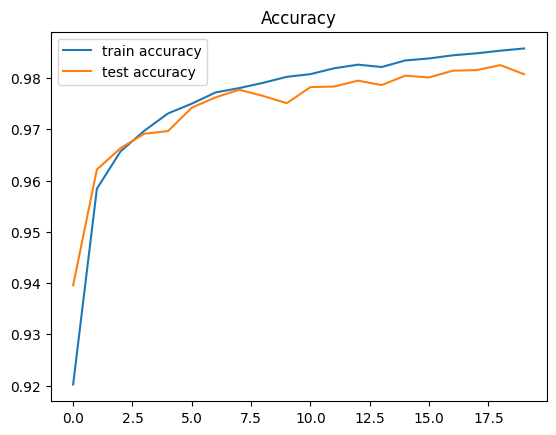

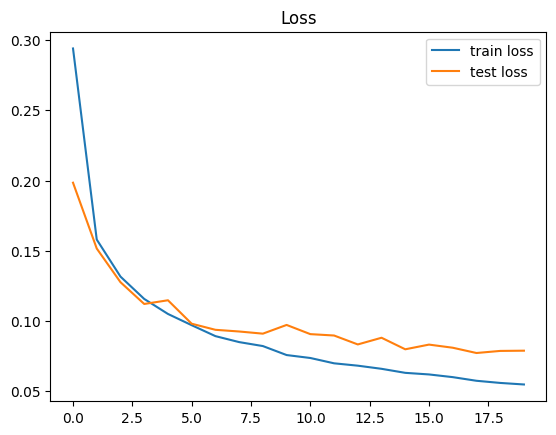

Training Accuracy: 98.54, Test Accuracy: 98.23
Training Loss: 5.63, Test Loss: 7.41
684/684 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


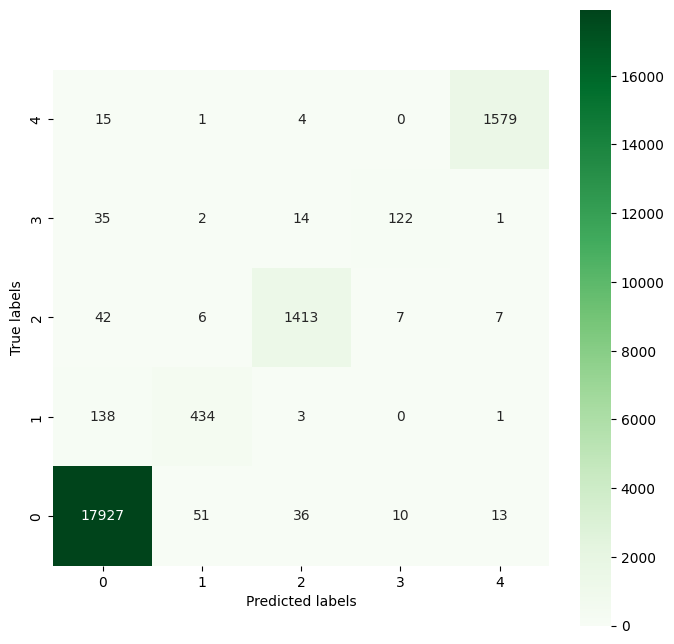

In [ ]:
# confusion matrix
def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # Normalized
    # con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    # con_mat_norm = np.around(con_mat_norm, decimals=2)

    # Plotting
    plt.figure(figsize=(8, 8))
    seaborn.heatmap(con_mat, annot=True, square=True, fmt='.20g', cmap='Greens')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

# plot accuracy during training
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy') # label is actually 'validation accuracy'
plt.legend()
plt.show()

# plot loss during training
plt.title('Loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss') # label is actually 'validation accuracy'
plt.legend()
plt.show()

# evaluate the model
train_loss, train_acc = model.evaluate(x_train, y_train_1d, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test_1d, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc*100, test_acc*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss*100, test_loss*100))

# predict
Y_pred = np.argmax(model.predict(x_test), axis=-1)
# Y_pred = model.predict_classes(X_test)
# plot confusion matrix
plotHeatMap(y_test_1d, Y_pred)

In [ ]:
# Per class accuracy printing function
def _report(TN, FP, FN, TP):
    TPR = TP/(TP+FN) if (TP+FN)!=0 else 0
    TNR = TN/(TN+FP) if (TN+FP)!=0 else 0
    PPV = TP/(TP+FP) if (TP+FP)!=0 else 0
    '''
    report = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
              'TPR': TPR, 'Recall': TPR, 'Sensitivity': TPR,
              'TNR' : TNR, 'Specificity': TNR,
              'FPR': FP/(FP+TN) if (FP+TN)!=0 else 0,
              'FNR': FN/(FN+TP) if (FN+TP)!=0 else 0,
              'PPV': PPV, 'Precision': PPV,
              'F1 Score': 2*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy': (TP+TN)/(TP+FP+FN+TN)
             }'''

    report = {'Sensitivity (%)': TPR*100,
              'Specificity (%)': TNR*100,
              'F1 Score (%)': 2*100*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy (%)': (TP+TN)*100/(TP+FP+FN+TN)
             }
    return report

def multi_classification_report(y_test, y_pred, labels=None, encoded_labels=True, as_frame=False):
    """
    Args:
        y_test (ndarray)
        y_pred (ndarray)
        labels (list)
        encoded_labels (bool): Need to be False if labels are not one hot encoded
        as_fram (bool): If True, return type will be DataFrame

    Return:
        report (dict)
    """

    import numpy as np
    import pandas as pd
    from sklearn.metrics import multilabel_confusion_matrix

    conf_labels = None if encoded_labels else labels

    conf_mat = multilabel_confusion_matrix(y_test, y_pred, labels=conf_labels)
    report = dict()
    if labels == None:
        counter = np.arange(len(conf_mat))
    else:
        counter = labels

    for i, name in enumerate(counter):
        TN, FP, FN, TP = conf_mat[i].ravel()
        report[name] = _report(TN, FP, FN, TP)

    if as_frame:
        return pd.DataFrame(report)
    return report

# Per class performance
labels = ['N', 'S', 'V', 'F', 'Q']
Y_pred = np.argmax(model.predict(x_test), axis=-1)
multi_classification_report(y_test_1d, Y_pred, labels=labels, encoded_labels=True, as_frame=True)



684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


,N,S,V,F,Q
Sensitivity (%),99.390142,75.347222,95.796610,70.114943,98.749218
Specificity (%),93.985356,99.718111,99.720396,99.921612,99.891422
F1 Score (%),99.060618,81.121495,95.959253,77.955272,98.687500
Per Class Accuracy (%),98.444719,99.075980,99.455652,99.684369,99.807877


In [ ]:
prediction = model.predict(x_test[0:1])
prediction.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


(1, 5)

In [ ]:
from tensorflow.keras.models import load_model

# # Load the model
# model_path = "CAT.keras"  # Path to the saved model
# loaded_model = load_model('/content/drive/MyDrive/TinyML/'+model_path)

# Display information about the model
print("Model Summary:")
model.summary()

print("\nModel Config:")
print(model.get_config())

print("\nModel Layers:")
for i, layer in enumerate(model.layers):
    print(f"Layer {i + 1}: {layer.name}, Type: {layer.__class__.__name__}")


Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 300, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 300, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 150, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 150, 16)             │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 75, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          38,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,089 (457.38 KB)

 Trainable params: 39,029 (152.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 78,060 (304.93 KB)


Model Config:
{'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 300), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'reshape', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'target_shape': (300, 1)}, 'registered_name': None, 'build_config': {'input_shape': (None, 300)}}, {'module': 'keras.layers', 'class_name': 'Conv1D', 'config': {'name': 'conv1d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 8, 'kernel_size': (3,), 'strides': (1,), 'padding': 'same', 'data_format': 'channels_last', 'dil

In [ ]:
# Calculate model size
import os
model_size = os.path.getsize('/content/drive/MyDrive/TinyML/mit-bih-arrhythmia-database-1.0.0/1_model.h5') / (1024 * 1024)  # Size in MB
print(f"\nModel File Size: {model_size:.2f} MB")
# Calculate model complexity (number of parameters)
trainable_params = sum([layer.count_params() for layer in model.layers if layer.trainable])
non_trainable_params = sum([layer.count_params() for layer in model.layers if not layer.trainable])
total_params = trainable_params + non_trainable_params

print(f"\nModel Complexity:")
print(f"  Trainable Parameters: {trainable_params:,}")
print(f"  Non-trainable Parameters: {non_trainable_params:,}")
print(f"  Total Parameters: {total_params:,}")


Model File Size: 1.14 MB

Model Complexity:
  Trainable Parameters: 94,405
  Non-trainable Parameters: 0
  Total Parameters: 94,405


In [ ]:
import os
import tensorflow as tf

# Convert the model to the TensorFlow Lite format with quantization
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converter.convert()

converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable post-training quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Use default optimization for size reduction
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Use TFLite ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TF ops
]

# Disable experimental lowering of tensor list operations
converter._experimental_lower_tensor_list_ops = False

# Enable resource variable handling
converter.experimental_enable_resource_variables = True

# Convert the model with quantization
tflite_model = converter.convert()

# Set a specific file path for saving the quantized model
model_file_name = os.path.join('/content/drive/MyDrive/TinyML/2.tflite')  # Replace '/path/to/directory' with your desired path

# Save the quantized model to the specified file path
with open(model_file_name, 'wb') as f:
    f.write(tflite_model)

# Print the full path of the saved model
model_file_path = os.path.abspath(model_file_name)
print(f"The quantized TFLite model is saved at: {model_file_path}")

# Use xxd to convert the quantized model to C++ source code for embedding into Arduino
!apt-get -qq install xxd
!xxd -i /content/drive/MyDrive/TinyML/2.tflite > /content/drive/MyDrive/TinyML/2.cpp
!cat /content/drive/MyDrive/TinyML/2.cpp


Saved artifact at '/tmp/tmp2i16ptke'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136972386241808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136972386254480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136972386253904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136972386243728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136972371395984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136972371396560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136972371394640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136972371397328: TensorSpec(shape=(), dtype=tf.resource, name=None)
The quantized TFLite model is saved at: /content/drive/MyDrive/TinyML/1.tflite
unsigned char _content_drive_MyDrive_TinyML_1_tflite[] = {
  0x20, 0x00, 0x00, 0x0

In [ ]:
!ls -lh /content/drive/MyDrive/TinyML/1.tflite

-rw------- 1 root root 47K Feb  4 05:33 /content/drive/MyDrive/TinyML/1.tflite


In [ ]:
!ls -lh /content/drive/MyDrive/TinyML/1.cpp

-rw------- 1 root root 287K Feb  4 05:33 /content/drive/MyDrive/TinyML/1.cpp


In [ ]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sys import getsizeof

In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [ ]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [ ]:
from tensorflow.keras.models import load_model

# Specify the correct path to your model
# model_path = '/content/drive/MyDrive/TinyML/mit-bih-arrhythmia-database-1.0.0/1_model.h5'

# Load the model
model = load_model(model_path)

# Verify the model summary
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_6 (Reshape)                  │ (None, 300, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 300, 48)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 300, 48)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ (None, 300, 64)             │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 300, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 300, 96)             │          18,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 300, 96)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 96)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 256)                 │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,407 (368.78 KB)

 Trainable params: 94,405 (368.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
# model_path="/content/drive/MyDrive/TinyML/mit-bih-arrhythmia-database-1.0.0/1_model.h5"
convert_bytes(get_file_size(model_path), "MB")

File size: 0.153 Megabytes


In [ ]:
keras_model_size = get_file_size(model_path)
test_loss, test_acc = model.evaluate(x_test, y_test_1d, verbose=2)
print('\nTest accuracy is {}%'.format(round(100*test_acc, 2)))

684/684 - 4s - 6ms/step - accuracy: 0.9580 - loss: 0.1520

Test accuracy is 95.8%


In [ ]:
TF_LITE_MODEL_FILE_NAME = "3_tf_lite_model.tflite"

In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.experimental_new_converter = False  # Disable new converter
tflite_model = tf_lite_converter.convert()


In [ ]:
import tensorflow as tf

@tf.function(input_signature=[tf.TensorSpec(shape=[1, 300, 1], dtype=tf.float32)])
def wrapped_model(inputs):
    return model(inputs)

tf_lite_converter = tf.lite.TFLiteConverter.from_concrete_functions(
    [wrapped_model.get_concrete_function()]
)
tflite_model = tf_lite_converter.convert()


In [ ]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

41152

In [ ]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

File size: 42.527 Kilobytes


In [ ]:
tflite_file_size = get_file_size(TF_LITE_MODEL_FILE_NAME)

In [ ]:
print(x_train.shape,y_train_1d.shape)
print(x_test.shape,y_test_1d.shape)

(87444, 300) (87444,)
(21861, 300) (21861,)


In [ ]:
len(y_test_1d)

21861

In [ ]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:",  )
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape:
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float32'>


In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (21861, 300))
interpreter.resize_tensor_input(output_details[0]['index'], (21861, 5))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [21861   300]
Input Type: <class 'numpy.float32'>
Output Shape: [21861     5]
Output Type: <class 'numpy.float32'>


In [ ]:
x_test.dtype

dtype('float64')

In [ ]:
x_test_numpy = np.array(x_test, dtype=np.float32)

In [ ]:
x_test_numpy.dtype

dtype('float32')

In [ ]:
interpreter.set_tensor(input_details[0]['index'], x_test_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (21861, 5)


In [ ]:
acc = accuracy_score(prediction_classes, y_test_1d)

In [ ]:
print('Test accuracy TFLITE model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE model is 95.8%


In [ ]:
tflite_file_size/keras_model_size

0.27096918711732787

In [ ]:
TF_LITE_MODEL_FLOAT_16_FILE_NAME = "3_tf_lite_float_16_model.tflite"

In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_converter.convert()

Saved artifact at '/tmp/tmp898wdpgk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 1), dtype=tf.float32, name='input_layer_12')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137451663087504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663089808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663089232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663090576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663090000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663091344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663090768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663092112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663091536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663092880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663092304: 

In [ ]:
tflite_model_name = TF_LITE_MODEL_FLOAT_16_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

26728

In [ ]:
convert_bytes(get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME), "KB")

File size: 26.102 Kilobytes


In [ ]:
tflite_float_16_file_size = get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME)

In [ ]:
tflite_float_16_file_size/keras_model_size

0.16630992085220767

In [ ]:
tflite_float_16_file_size/tflite_file_size

0.6137595297143382

In [ ]:
TF_LITE_SIZE_QUANT_MODEL_FILE_NAME = "3_tf_lite_quant_model.tflite"

In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = tf_lite_converter.convert()

Saved artifact at '/tmp/tmpi_ajj60l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 1), dtype=tf.float32, name='input_layer_12')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137451663087504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663089808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663089232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663090576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663090000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663091344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663090768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663092112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663091536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663092880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451663092304: 

In [ ]:
tflite_model_name = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

19480

In [ ]:
convert_bytes(get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME), "KB")

File size: 19.023 Kilobytes


In [ ]:
tflite_float_quant_file_size = get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)

In [ ]:
tflite_float_quant_file_size/keras_model_size

0.12121061277315943

In [ ]:
tflite_float_quant_file_size/ tflite_float_16_file_size

0.7288237054774019

In [ ]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 300   1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float32'>


In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (21861, 300))
interpreter.resize_tensor_input(output_details[0]['index'], (21861, 5))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [21861   300]
Input Type: <class 'numpy.float32'>
Output Shape: [21861     5]
Output Type: <class 'numpy.float32'>


In [ ]:
x_test.dtype

dtype('float64')

In [ ]:
x_test_numpy = np.array(x_test, dtype=np.float32)

In [ ]:
interpreter.set_tensor(input_details[0]['index'], x_test_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (21861, 5)


In [ ]:
acc = accuracy_score(prediction_classes, y_test_1d)

In [ ]:
print('Test accuracy TFLITE Quantized model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE Quantized model is 95.76%


In [ ]:
"3_tf_lite_quant_model.tflite"

'3_tf_lite_quant_model.tflite'

In [ ]:
!apt-get -qq install xxd
!xxd -i 3_tf_lite_model.tflite > 3_tf_lite_model.cpp
!cat 3_tf_lite_model.cpp

unsigned char __3_tf_lite_model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x74, 0x00, 0x00, 0x00, 0x18, 0x91, 0x00, 0x00,
  0x28, 0x91, 0x00, 0x00, 0x1c, 0xa0, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x34, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0xdc, 0xff, 0xff, 0xff, 0x1e, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00, 0x43, 0x4f, 0x4e, 0x56,
  0x45, 0x52, 0x53, 0x49, 0x4f, 0x4e, 0x5f, 0x4d, 0x45, 0x54, 0x41, 0x44,
  0x41, 0x54, 0x41, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x08, 0x00, 0x00, 0x00, 0x1d, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f, 0x72, 0x75, 0x6e, 0x74,
  0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73, 0x69, 0x6f, 0x6e,

In [ ]:
convert_bytes(get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME), "KB")

File size: 19.023 Kilobytes


In [ ]:
!ls -lh 3_tf_lite_model.tflite

-rw------- 1 root root 41K Feb  5 16:41 3_tf_lite_model.tflite


In [ ]:
!ls -lh 3_tf_lite_model.cpp


-rw------- 1 root root 248K Feb  5 16:43 3_tf_lite_model.cpp


In [ ]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="tf_lite_quant_model.tflite")
interpreter.allocate_tensors()


In [ ]:
interpreter = tf.lite.Interpreter(model_path=model_path)
try:
    interpreter.allocate_tensors()
    print("Model loaded and tensors allocated successfully!")
except Exception as e:
    print(f"Error loading model: {e}")


Model loaded and tensors allocated successfully!


In [ ]:
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Details:", input_details)
print("Output Details:", output_details)


Input Details: [{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([  1, 300], dtype=int32), 'shape_signature': array([ -1, 300], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 36, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([-1,  5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
import traceback

try:
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
except Exception as e:
    print("Error loading model:")
    traceback.print_exc()
